Total amount of images: 354
Dataset contains 708 image pairs
Train contains 566 image pairs
Validation contains 70 image pairs
Test contains 72 image pairs


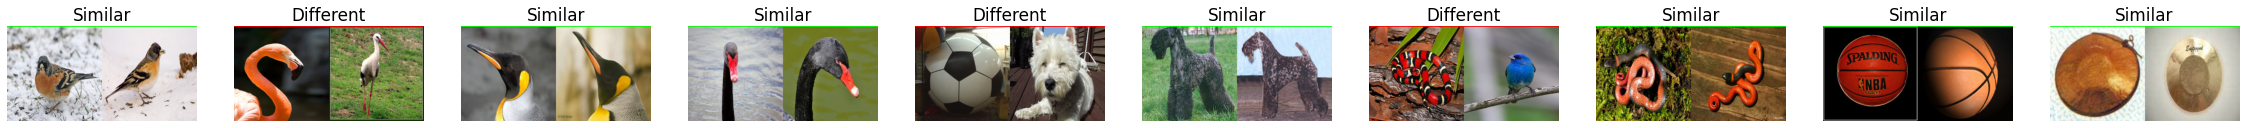

In [1]:
import sys
sys.path.append('../../utility')
import util
import numpy as np

folders = util.load_images('../../data/dataset_pairs')
data, labels = util.create_pairs(folders)

data, labels = util.shuffle_data(data, labels)
data_split, labels_split = util.split_data(data, labels)
data_train, data_val, data_test = data_split
labels_train, labels_val, labels_test = labels_split

print('Dataset contains', data.shape[0], 'image pairs')
print('Train contains', data_train.shape[0], 'image pairs')
print('Validation contains', data_val.shape[0], 'image pairs')
print('Test contains', data_test.shape[0], 'image pairs')

util.visualize(data_train, labels_train)

In [2]:
# Import libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import BatchNormalization, Dot
from keras.metrics import BinaryAccuracy
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Conv2D
from keras.losses import CosineSimilarity
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2

In [3]:

# Inputs
# inputs = [Input(input_shape), Input(input_shape)]

# Feature Extraction Model
# feature_extractor_layer = feature_extraction_model(inputs)

# # Distance layer LAMBDA
# # distance_layer = Lambda(util.pairwise_euclidean_distance)(feature_extractor_layer) 

# merge_layer = Lambda(util.pairwise_euclidean_distance)(feature_extractor_layer)
# normal_layer = BatchNormalization()(merge_layer)
# output_layer = Dense(1, activation='sigmoid', dtype='float32')(normal_layer)

input_shape = (224, 224, 3)

# Source <https://keras.io/examples/vision/siamese_contrastive/>

embedding_extractor = Sequential(name='embedding_extractor')
base_model = MobileNetV2(input_shape=(input_shape), include_top = False, weights='imagenet')
base_model.trainable = False
embedding_extractor.add(base_model)
embedding_extractor.add(Dropout(0.3))
embedding_extractor.add(Dense(1280, activation='relu'))
# embedding_extractor.add(Dropout(0.5))
# embedding_extractor.add(Dense(64, activation='relu'))
embedding_extractor.add(GlobalAveragePooling2D())


embedding_extractor.compile()

# Input pair
input_image_1 = Input(input_shape)
input_image_2 = Input(input_shape)

# Output pair
encoded_image_1 = embedding_extractor(input_image_1)
encoded_image_2 = embedding_extractor(input_image_2)

similarity = Dot(axes=(1), normalize=True)([encoded_image_1, encoded_image_2])

# Full Model
siamese = Model(inputs=[input_image_1, input_image_2], outputs=similarity, name='model')

siamese.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[BinaryAccuracy()])

siamese.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding_extractor (Sequentia  (None, 1280)        3897664     ['input_2[0][0]',                
 l)                                                               'input_3[0][0]']            

In [4]:
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 0.0005
DECAY_RATE = 1e-5

history = siamese.fit(
    [data_train[:, 0], data_train[:, 1]], 
    labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
    validation_data=([data_val[:, 0], data_val[:, 1]], labels_val))

# evaluate
score = siamese.evaluate(
    [data_test[:, 0], data_test[:, 1]], 
    labels_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/3
18/18 [==============================] - 14s 584ms/step - loss: 0.3765 - binary_accuracy: 0.8251 - val_loss: 0.1271 - val_binary_accuracy: 1.0000
Epoch 2/3
18/18 [==============================] - 10s 539ms/step - loss: 0.0742 - binary_accuracy: 0.9982 - val_loss: 0.0545 - val_binary_accuracy: 1.0000
Epoch 3/3
18/18 [==============================] - 10s 534ms/step - loss: 0.0280 - binary_accuracy: 1.0000 - val_loss: 0.0360 - val_binary_accuracy: 1.0000
Test loss: 0.07447611540555954
Test accuracy: 0.9861111044883728


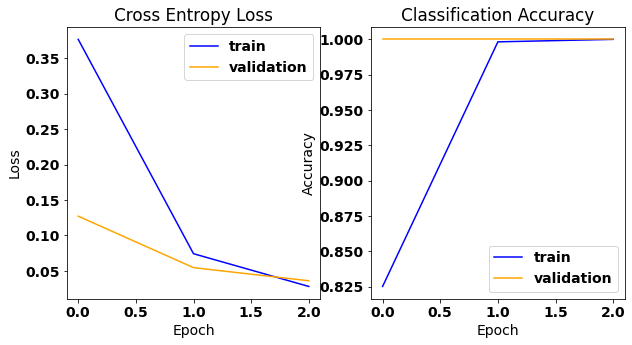

In [5]:
# plot diagnostic learning curves
plt.rcParams.update({'text.color': '#000000'})

def summarize_diagnostics(history):
    	    	
	# plot loss
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	
	ax[0].set_title('Cross Entropy Loss')
	ax[0].set_xlabel('Epoch')
	ax[0].set_ylabel('Loss')
	ax[0].plot(history.history['loss'], color='blue', label='train')
	ax[0].plot(history.history['val_loss'], color='orange', label='validation')
	ax[0].legend()

	# plot accuracy
	ax[1].set_title('Classification Accuracy')
	ax[1].set_xlabel('Epoch')
	ax[1].set_ylabel('Accuracy')
	ax[1].plot(history.history['binary_accuracy'], color='blue', label='train')
	ax[1].plot(history.history['val_binary_accuracy'], color='orange', label='validation')
	ax[1].legend()
	
	plt.show()

summarize_diagnostics(history)

In [6]:
embedding_extractor.save('./binary_cross_entropy_loss_embedding_extractor.h5')
siamese.save('./binary_cross_entropy_loss_siamese.h5')

In [46]:
!tensorflowjs_converter --input_format keras --weight_shard_size_bytes 1073741824 ./binary_cross_entropy_loss_embedding_extractor.h5 .

In [48]:
!tensorflowjs_converter --input_format keras --weight_shard_size_bytes 1073741824 ./binary_cross_entropy_loss_siamese.h5 ./siamese_model/